<a href="https://colab.research.google.com/github/ArchanaShivakumar111/Ocular-Disease-Detection/blob/main/OcularDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet timm albumentations opencv-python-headless matplotlib pandas scikit-learn torchmetrics openpyxl
import sys, importlib
packages = ["torch", "timm", "albumentations", "cv2", "matplotlib", "pandas", "sklearn"]
for p in packages:
    try:
        mod = importlib.import_module(p if p!="cv2" else "cv2")
        print(p, getattr(mod, "__version__", "version-ok"))
    except Exception as e:
        print(p, "import error:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.1 MB/s eta 0:00:00
torch 2.8.0+cu126
timm 1.0.21
albumentations 2.0.8
cv2 4.12.0
matplotlib 3.10.0
pandas 2.2.2
sklearn 1.6.1


In [ ]:
from google.colab import files
uploaded = files.upload()
if "kaggle.json" in uploaded:
    print("kaggle.json uploaded to the Colab session.")
else:
    print("No kaggle.json found in uploaded files. Please upload the file you downloaded from Kaggle (kaggle.json).")


Saving kaggle.json to kaggle.json
kaggle.json uploaded to the Colab session.


In [ ]:
# install kaggle CLI if not present
!pip install --quiet kaggle

# create .kaggle folder and move the uploaded file there
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# if file present in runtime, move it (this will overwrite a previous one if any)
if "kaggle.json" in globals().get('uploaded', {}):
    open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb").write(uploaded["kaggle.json"])
    print("Moved kaggle.json to ~/.kaggle/kaggle.json")
else:
    # If you used Colab file upload GUI previously, the file may already be in the working dir; try to move it:
    if os.path.exists("kaggle.json"):
        os.replace("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
        print("Found kaggle.json in working dir and moved it to ~/.kaggle/kaggle.json")
    else:
        print("kaggle.json not found in session. Re-run upload cell and select kaggle.json.")

# set permissions
os.system("chmod 600 ~/.kaggle/kaggle.json")

# sanity check: list the file
print("Listing ~/.kaggle:")
!ls -la ~/.kaggle


Moved kaggle.json to ~/.kaggle/kaggle.json
Listing ~/.kaggle:
total 16
drwxr-xr-x 2 root root 4096 Nov  7 10:27 .
drwx------ 1 root root 4096 Nov  7 10:27 ..
-rw------- 1 root root   73 Nov  7 10:27 kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p /content --unzip --force


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 98% 1.60G/1.62G [00:16<00:00, 69.9MB/s]
100% 1.62G/1.62G [00:22<00:00, 79.1MB/s]


In [ ]:
!ls -l /content/ODIR-5K/ODIR-5K


total 564
-rw-r--r-- 1 root root 268198 Nov  7 10:28  data.xlsx
drwxr-xr-x 2 root root  36864 Nov  7 10:28 'Testing Images'
drwxr-xr-x 2 root root 266240 Nov  7 10:28 'Training Images'


In [ ]:
# Cell 1 — set paths and confirm they exist
from pathlib import Path

# This is the inner folder you found
BASE = Path("/content/ODIR-5K/ODIR-5K")

# Exact names shown in your ls output
IMAGE_DIR = BASE / "Training Images"    # folder with training images (note the space)
TEST_DIR  = BASE / "Testing Images"     # folder with test images (not used now)
ANNOTATION_PATH = BASE / "data.xlsx"    # Excel annotation file

print("BASE:", BASE)
print("BASE exists?:", BASE.exists())
print("IMAGE_DIR:", IMAGE_DIR)
print("IMAGE_DIR exists?:", IMAGE_DIR.exists())
print("TEST_DIR:", TEST_DIR)
print("TEST_DIR exists?:", TEST_DIR.exists())
print("ANNOTATION_PATH:", ANNOTATION_PATH)
print("ANNOTATION exists?:", ANNOTATION_PATH.exists())


BASE: /content/ODIR-5K/ODIR-5K
BASE exists?: True
IMAGE_DIR: /content/ODIR-5K/ODIR-5K/Training Images
IMAGE_DIR exists?: True
TEST_DIR: /content/ODIR-5K/ODIR-5K/Testing Images
TEST_DIR exists?: True
ANNOTATION_PATH: /content/ODIR-5K/ODIR-5K/data.xlsx
ANNOTATION exists?: True


In [ ]:
# Cell 2 — load and inspect the Excel annotation file
import pandas as pd

# read Excel (pandas uses openpyxl which you installed earlier)
raw_ann = pd.read_excel(ANNOTATION_PATH, engine="openpyxl")
print("Annotation shape:", raw_ann.shape)
print("\nColumn names:")
print(raw_ann.columns.tolist())

print("\nFirst 8 rows (for quick inspection):")
display(raw_ann.head(8))


Annotation shape: (3500, 15)

Column names:
['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

First 8 rows (for quick inspection):


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
# Cell 3 — convert the annotation table into a per-eye table
import numpy as np
import pandas as pd
import re

def build_per_eye_df_from_raw(df):
    # Work with lowercase names for detection
    lc = {c.lower().strip(): c for c in df.columns}
    cols_lower = list(lc.keys())

    # Try detect common columns
    # 1) filename-like column
    filename_col = None
    for cand in ['image', 'filename', 'file_name', 'file', 'image_name', 'image path', 'image_path']:
        if cand in lc:
            filename_col = lc[cand]; break

    # 2) left/right diagnosis columns (patient-level)
    left_diag = None
    right_diag = None
    for cand in ['left-fundus', 'left fundus', 'left', 'left_diagnostic keywords', 'left_diagnostic', 'left diagnostic keywords', 'left diagnostic']:
        if cand in lc:
            left_diag = lc[cand]; break
    for cand in ['right-fundus', 'right fundus', 'right', 'right_diagnostic keywords', 'right_diagnostic', 'right diagnostic keywords', 'right diagnostic']:
        if cand in lc:
            right_diag = lc[cand]; break

    # 3) potential patient id column
    pid_col = None
    for cand in ['id', 'patient id', 'patientid', 'patient_id', 'case id']:
        if cand in lc:
            pid_col = lc[cand]; break

    rows = []
    if filename_col is not None:
        # annotation is per-image; copy filename and label column (try to find diagnostic column)
        label_col = None
        for cand in ['left-diagnostic keywords', 'diagnostic keywords', 'diagnostic', 'diagnosis', 'labels', 'label', 'disease']:
            if cand in lc:
                label_col = lc[cand]; break
        for _, r in df.iterrows():
            fname = r[filename_col]
            if pd.isna(fname):
                continue
            lbl = r[label_col] if label_col is not None and not pd.isna(r[label_col]) else ""
            rows.append({"image_token": str(fname).strip(), "labels": str(lbl).strip()})
    elif left_diag is not None or right_diag is not None:
        # Expand patient-level rows into two eye-rows
        # sometimes left/right image filenames are in other columns (try to detect)
        left_img_col = None
        right_img_col = None
        for cand in ['left image', 'left_image', 'left filename', 'left_image_name', 'left_img']:
            if cand in lc:
                left_img_col = lc[cand]; break
        for cand in ['right image', 'right_image', 'right filename', 'right_image_name', 'right_img']:
            if cand in lc:
                right_img_col = lc[cand]; break

        for _, r in df.iterrows():
            pid = r[pid_col] if pid_col else None
            if left_diag and not pd.isna(r[left_diag]):
                lbl = r[left_diag]
                fname = None
                if left_img_col and not pd.isna(r[left_img_col]):
                    fname = r[left_img_col]
                else:
                    # fallback: construct token using patient id + left
                    fname = f"{str(pid).strip()}_left" if pid is not None else None
                rows.append({"image_token": str(fname).strip() if fname is not None else None, "labels": str(lbl).strip()})
            if right_diag and not pd.isna(r[right_diag]):
                lbl = r[right_diag]
                fname = None
                if right_img_col and not pd.isna(r[right_img_col]):
                    fname = r[right_img_col]
                else:
                    fname = f"{str(pid).strip()}_right" if pid is not None else None
                rows.append({"image_token": str(fname).strip() if fname is not None else None, "labels": str(lbl).strip()})
    else:
        raise RuntimeError("Could not detect annotation format automatically. Inspect raw DataFrame columns printed earlier and tell me the names if you want me to adapt.")

    per_eye = pd.DataFrame(rows)
    print("Built per-eye table with shape:", per_eye.shape)
    return per_eye

per_eye_df = build_per_eye_df_from_raw(raw_ann)
per_eye_df.head(10)


Built per-eye table with shape: (7000, 2)


,image_token,labels
0,0_left,0_left.jpg
1,0_right,0_right.jpg
2,1_left,1_left.jpg
3,1_right,1_right.jpg
4,2_left,2_left.jpg
5,2_right,2_right.jpg
6,3_left,3_left.jpg
7,3_right,3_right.jpg
8,4_left,4_left.jpg
9,4_right,4_right.jpg


In [ ]:
# Cell 4 — parse label text into ODIR label codes and a fixed multi-hot vector
ODIR_LABELS = ['N','D','G','C','A','H','M','O']   # order matters

import numpy as np
import re

def parse_label_string(label_str):
    if pd.isna(label_str) or str(label_str).strip()=="":
        return []
    s = str(label_str)
    tokens = [t.strip().upper() for t in re.split(r'[;,/|]', s) if t.strip()]
    found = set()
    # direct code detection
    for t in tokens:
        if t in ODIR_LABELS:
            found.add(t)
    if found:
        return sorted(found)
    low = s.lower()
    if 'diabet' in low: found.add('D')
    if 'glau' in low: found.add('G')
    if 'catar' in low: found.add('C')
    if 'age' in low or 'macul' in low or 'amd' in low: found.add('A')
    if 'hyper' in low or 'blood pressure' in low: found.add('H')
    if 'myop' in low: found.add('M')
    if 'normal' in low or 'no finding' in low or low.strip() in ['n','healthy']: found.add('N')
    if not found and s.strip(): found.add('O')
    return sorted(found)

def labels_to_multihot(lbl_list):
    vec = np.zeros(len(ODIR_LABELS), dtype=np.float32)
    for lbl in lbl_list:
        if lbl in ODIR_LABELS:
            vec[ODIR_LABELS.index(lbl)] = 1.0
    return vec

per_eye_df['parsed_labels'] = per_eye_df['labels'].apply(parse_label_string)
per_eye_df['label_vec'] = per_eye_df['parsed_labels'].apply(labels_to_multihot)

per_eye_df[['image_token','labels','parsed_labels']].head(10)


,image_token,labels,parsed_labels
0,0_left,0_left.jpg,[O]
1,0_right,0_right.jpg,[O]
2,1_left,1_left.jpg,[O]
3,1_right,1_right.jpg,[O]
4,2_left,2_left.jpg,[O]
5,2_right,2_right.jpg,[O]
6,3_left,3_left.jpg,[O]
7,3_right,3_right.jpg,[O]
8,4_left,4_left.jpg,[O]
9,4_right,4_right.jpg,[O]


In [ ]:
# Cell 5 — find actual image file paths for each token by trying several filename patterns
from pathlib import Path
import os

TRAIN_DIR = IMAGE_DIR  # /content/ODIR-5K/ODIR-5K/Training Images
IMG_EXTS = [".jpg",".jpeg",".png",".tif",".tiff"]

def find_image_file(token, image_dir=TRAIN_DIR):
    if token is None or token == "None" or pd.isna(token):
        return None
    token = str(token).strip()
    # direct match
    cand = image_dir / token
    if cand.exists():
        return cand
    # try common extensions
    for ext in IMG_EXTS:
        cand = image_dir / (token + ext)
        if cand.exists():
            return cand
    # try suffixes/patterns: _left, _right, -left, -right, ' left', ' right'
    patt_suffixes = ['_left','_right','-left','-right',' left',' right','_L','_R',' L',' R']
    for s in patt_suffixes:
        for ext in IMG_EXTS:
            cand = image_dir / (token + s + ext)
            if cand.exists():
                return cand
    # sometimes the token is patient id only and filenames are like "ID_left.jpeg" or "ID left.jpeg".
    # try substring match across all files (slower but safe for small demos)
    for p in image_dir.iterdir():
        if p.is_file() and token in p.name:
            return p
    return None

# Apply mapping and show how many were found
per_eye_df['image_path'] = per_eye_df['image_token'].apply(lambda t: find_image_file(t))
missing = per_eye_df['image_path'].isna().sum()
print("Total rows:", len(per_eye_df), "Missing image_path:", missing)
per_eye_df.head(10)


Total rows: 7000 Missing image_path: 0


,image_token,labels,parsed_labels,label_vec,image_path
0,0_left,0_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/0_lef...
1,0_right,0_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/0_rig...
2,1_left,1_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/1_lef...
3,1_right,1_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/1_rig...
4,2_left,2_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/2_lef...
5,2_right,2_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/2_rig...
6,3_left,3_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/3_lef...
7,3_right,3_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/3_rig...
8,4_left,4_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/4_lef...
9,4_right,4_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/4_rig...


In [ ]:
# Cell 6 — filter and save
usable = per_eye_df.dropna(subset=['image_path']).reset_index(drop=True)
print("Usable rows (with found image files):", len(usable))

# Save a small index so you don't re-parse every time
usable[['image_path','parsed_labels','label_vec']].to_pickle("odir_per_eye_usables.pkl")
print("Saved index: odir_per_eye_usables.pkl")
usable.head(8)


Usable rows (with found image files): 7000
Saved index: odir_per_eye_usables.pkl


,image_token,labels,parsed_labels,label_vec,image_path
0,0_left,0_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/0_lef...
1,0_right,0_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/0_rig...
2,1_left,1_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/1_lef...
3,1_right,1_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/1_rig...
4,2_left,2_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/2_lef...
5,2_right,2_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/2_rig...
6,3_left,3_left.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/3_lef...
7,3_right,3_right.jpg,[O],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/content/ODIR-5K/ODIR-5K/Training Images/3_rig...


Train samples: 5600 Val samples: 1400


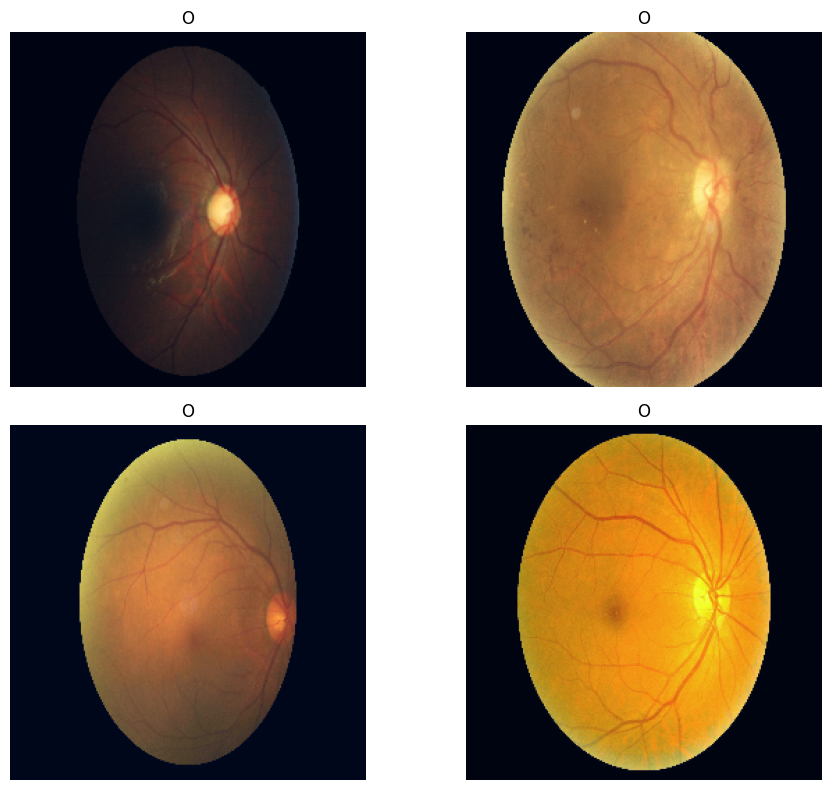

In [ ]:
# Cell 7 — Dataset, DataLoader, and quick visualization
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# simple transforms for demo
IMG_SIZE = 256
train_tfm = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), ToTensorV2()])
val_tfm = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), ToTensorV2()])

class ODIRDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = row['image_path']
        img = cv2.imread(str(p))                       # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # convert to RGB
        label = np.array(row['label_vec']).astype(np.float32)
        if self.transform:
            augmented = self.transform(image=img)
            img_t = augmented['image']
        else:
            img_t = torch.tensor(img.transpose(2,0,1).astype(np.float32)/255.0)
        return {"image": img_t, "labels": torch.tensor(label), "path": str(p)}

# small train/val split for demo
train_df, val_df = train_test_split(usable, test_size=0.2, random_state=42)
train_ds = ODIRDataset(train_df, transform=train_tfm)
val_ds   = ODIRDataset(val_df, transform=val_tfm)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

# visualize up to 4 samples
batch = next(iter(train_loader))
imgs = batch['image']   # (B,C,H,W)
labels = batch['labels']
def label_names(vec):
    names = [ODIR_LABELS[i] for i,x in enumerate(vec) if x>0.5]
    return ",".join(names) if names else "N (Normal)"

plt.figure(figsize=(10,8))
for i in range(min(4, imgs.size(0))):
    img_np = imgs[i].cpu().numpy().transpose(1,2,0)
    # simple rescale to 0-1 range for plotting
    img_np = (img_np - img_np.min())/(img_np.max()-img_np.min()+1e-8)
    plt.subplot(2,2,i+1)
    plt.imshow(img_np)
    plt.title(label_names(labels[i].numpy()))
    plt.axis('off')
plt.tight_layout()
plt.show()
